# Tubes KA K-NEAREST NEIGHBORS

Implementasi dari scratch:
1. Drop missing values
2. Train-test split stratified
3. Standardisasi
4. KNN dengan berbagai metric
5. Cross-validation
6. Grid search

In [1]:
import pandas as pd # untuk manipulasi data
import numpy as np # untuk operasi numerik
import matplotlib.pyplot as plt # untuk visualisasi data
import seaborn as sns # untuk visualisasi data

# Set style untuk visualisasi
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

## FUNGSI-FUNGSI

In [2]:
def train_test_split_stratified(X, y, test_size=0.2, random_state=42):
    """
    Split data menjadi train dan test set dengan stratifikasi.
    I.S. X: fitur, y: target
    F.S : X_train, X_test, y_train, y_test
    """
    np.random.seed(random_state)
    combined = X.copy()
    combined['_target_'] = y.values
    
    class_0 = combined[combined['_target_'] == 0]
    class_1 = combined[combined['_target_'] == 1]
    
    class_0_shuffled = class_0.sample(frac=1, random_state=random_state).reset_index(drop=True)
    class_1_shuffled = class_1.sample(frac=1, random_state=random_state).reset_index(drop=True)
    
    test_count_0 = int(len(class_0) * test_size)
    test_count_1 = int(len(class_1) * test_size)
    
    test_0 = class_0_shuffled[:test_count_0]
    train_0 = class_0_shuffled[test_count_0:]
    test_1 = class_1_shuffled[:test_count_1]
    train_1 = class_1_shuffled[test_count_1:]
    
    train_combined = pd.concat([train_0, train_1], ignore_index=True)
    test_combined = pd.concat([test_0, test_1], ignore_index=True)
    
    train_combined = train_combined.sample(frac=1, random_state=random_state).reset_index(drop=True)
    test_combined = test_combined.sample(frac=1, random_state=random_state).reset_index(drop=True)
    
    X_train = train_combined.drop('_target_', axis=1)
    y_train = train_combined['_target_']
    X_test = test_combined.drop('_target_', axis=1)
    y_test = test_combined['_target_']
    
    return X_train, X_test, y_train, y_test

In [3]:
def standardize(X_train, X_test):
    """
    Standardisasi Z-score.
    I.S. X_train, X_test: fitur
    F.S : X_train_scaled, X_test_scaled
    """
    mean = X_train.mean()
    std = X_train.std()
    X_train_scaled = (X_train - mean) / std
    X_test_scaled = (X_test - mean) / std
    return X_train_scaled, X_test_scaled

In [4]:
def calculate_distances_vectorized(X_test_point, X_train, metric='euclidean'):
    """
    Hitung jarak dari 1 test point ke semua training points (vectorized).
    I.S. X_test_point: 1 data point, X_train: semua training points
    F.S : array jarak
    """
    if metric == 'euclidean':
        return np.sqrt(np.sum((X_train - X_test_point) ** 2, axis=1))
    elif metric == 'manhattan':
        return np.sum(np.abs(X_train - X_test_point), axis=1)
    else:
        raise ValueError(f"Metric {metric} tidak didukung")

In [5]:
def knn_predict(X_train, y_train, X_test, k=5, metric='euclidean', weights='uniform'):
    """
    KNN dengan berbagai metric dan weights (optimized).
    I.S. X_train, y_train: data training; X_test: data test
    F.S : array prediksi untuk X_test
    """
    X_train_np = X_train.values
    X_test_np = X_test.values
    y_train_np = y_train.values if hasattr(y_train, "values") else np.array(y_train)
    
    predictions = []
    for x_test in X_test_np:
        # Hitung jarak ke semua training points (vectorized)
        distances = calculate_distances_vectorized(x_test, X_train_np, metric)
        
        # Ambil k tetangga terdekat (partial sort lebih cepat dari full sort)
        nearest_indices = np.argpartition(distances, k)[:k]
        nearest_labels = y_train_np[nearest_indices]
        nearest_distances = distances[nearest_indices]
        
        # Voting
        if weights == 'uniform':
            # Mayoritas sederhana dengan bincount (lebih cepat dari Counter)
            unique, counts = np.unique(nearest_labels, return_counts=True)
            pred = unique[np.argmax(counts)]
        elif weights == 'distance':
            # Weighted voting (1/distance)
            weights_arr = 1 / (nearest_distances + 1e-10)
            # Vectorized weighted sum per class
            unique_labels = np.unique(nearest_labels)
            weighted_votes = np.array(
                [
                    np.sum(
                        weights_arr[nearest_labels == label]
                    ) for label in unique_labels
                ]
            )
            pred = unique_labels[np.argmax(weighted_votes)]
        else:
            raise ValueError(f"Weights {weights} tidak didukung")
        
        predictions.append(pred)
    
    return np.array(predictions)

In [6]:
def accuracy(y_true, y_pred):
    """
    Hitung akurasi.
    I.S. y_true: label asli, y_pred: label prediksi
    F.S : akurasi (float)
    """
    return np.sum(y_true == y_pred) / len(y_true)


In [7]:
def confusion_matrix(y_true, y_pred):
    """
    Hitung confusion matrix.
    I.S. y_true: label asli, y_pred: label prediksi
    F.S : confusion matrix (2D array)
    """
    classes = np.unique(np.concatenate([y_true, y_pred]))
    cm = np.zeros((len(classes), len(classes)), dtype=int)
    
    for true, pred in zip(y_true, y_pred):
        true_idx = np.where(classes == true)[0][0]
        pred_idx = np.where(classes == pred)[0][0]
        cm[true_idx, pred_idx] += 1
    
    return cm

In [8]:
def cross_validate(X, y, k, metric, weights, n_folds=5):
    """
    Cross-validation KNN.
    I.S. X, y: data; k, metric, weights: hyperparameter; n_folds: jumlah fold
    F.S : mean accuracy, std accuracy
    """
    np.random.seed(42)
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    
    fold_size = len(X) // n_folds
    scores = []
    
    for fold in range(n_folds):
        # Split indices
        test_start = fold * fold_size
        test_end = test_start + fold_size if fold < n_folds - 1 else len(X)
        
        test_indices = indices[test_start:test_end]
        train_indices = np.concatenate([indices[:test_start], indices[test_end:]])
        
        # Split data
        X_fold_train = X.iloc[train_indices].reset_index(drop=True)
        y_fold_train = y.iloc[train_indices].reset_index(drop=True)
        X_fold_test = X.iloc[test_indices].reset_index(drop=True)
        y_fold_test = y.iloc[test_indices].reset_index(drop=True)
        
        # Preprocess (hanya standardisasi, data sudah bersih)
        X_fold_train, X_fold_test = standardize(X_fold_train, X_fold_test)        
        
        # Predict
        y_pred = knn_predict(X_fold_train, y_fold_train, X_fold_test, k, metric, weights)
        
        # Score
        scores.append(accuracy(y_fold_test.values, y_pred))
    
    return np.mean(scores), np.std(scores)

In [9]:
def cap_outliers(X_train, X_test):
    """
    Outlier capping menggunakan metode IQR.
    I.S. X_train, X_test: fitur sebelum capping
    F.S : X_train_capped, X_test_capped
    """
    # Hitung IQR bounds dari TRAIN SET saja (mencegah data leakage)
    outlier_bounds = {}
    
    for col in X_train.columns:
        Q1 = X_train[col].quantile(0.25)
        Q3 = X_train[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        outlier_bounds[col] = (lower, upper)
    
    # Terapkan bounds ke train dan test set
    X_train_capped = X_train.copy()
    X_test_capped = X_test.copy()
    
    for col in X_train.columns:
        lower, upper = outlier_bounds[col]
        X_train_capped[col] = X_train_capped[col].clip(lower, upper)
        X_test_capped[col] = X_test_capped[col].clip(lower, upper)
    
    return X_train_capped, X_test_capped

## MAIN PROGRAM

### 1. LOAD DATASET & CLEANING

In [10]:
df = pd.read_csv("data/water_potability.csv")

print(f"Data awal: {df.shape}")
print(f"Missing values: {df.isnull().sum().sum()}")

# Hapus missing values
df = df.dropna()
print(f"Setelah drop missing: {df.shape}")

df = df.drop_duplicates()
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna()  # Drop lagi jika ada inf yang jadi NaN

Data awal: (3276, 10)
Missing values: 1434
Setelah drop missing: (2011, 10)


In [11]:
# Simpan data mentah dulu (outlier capping akan dilakukan setelah split)
print(f"Data final setelah cleaning: {df.shape}")

# Definisikan features untuk visualisasi
features = df.drop('Potability', axis=1).columns

Data final setelah cleaning: (2011, 10)


### 1a. VISUALISASI DATA AWAL

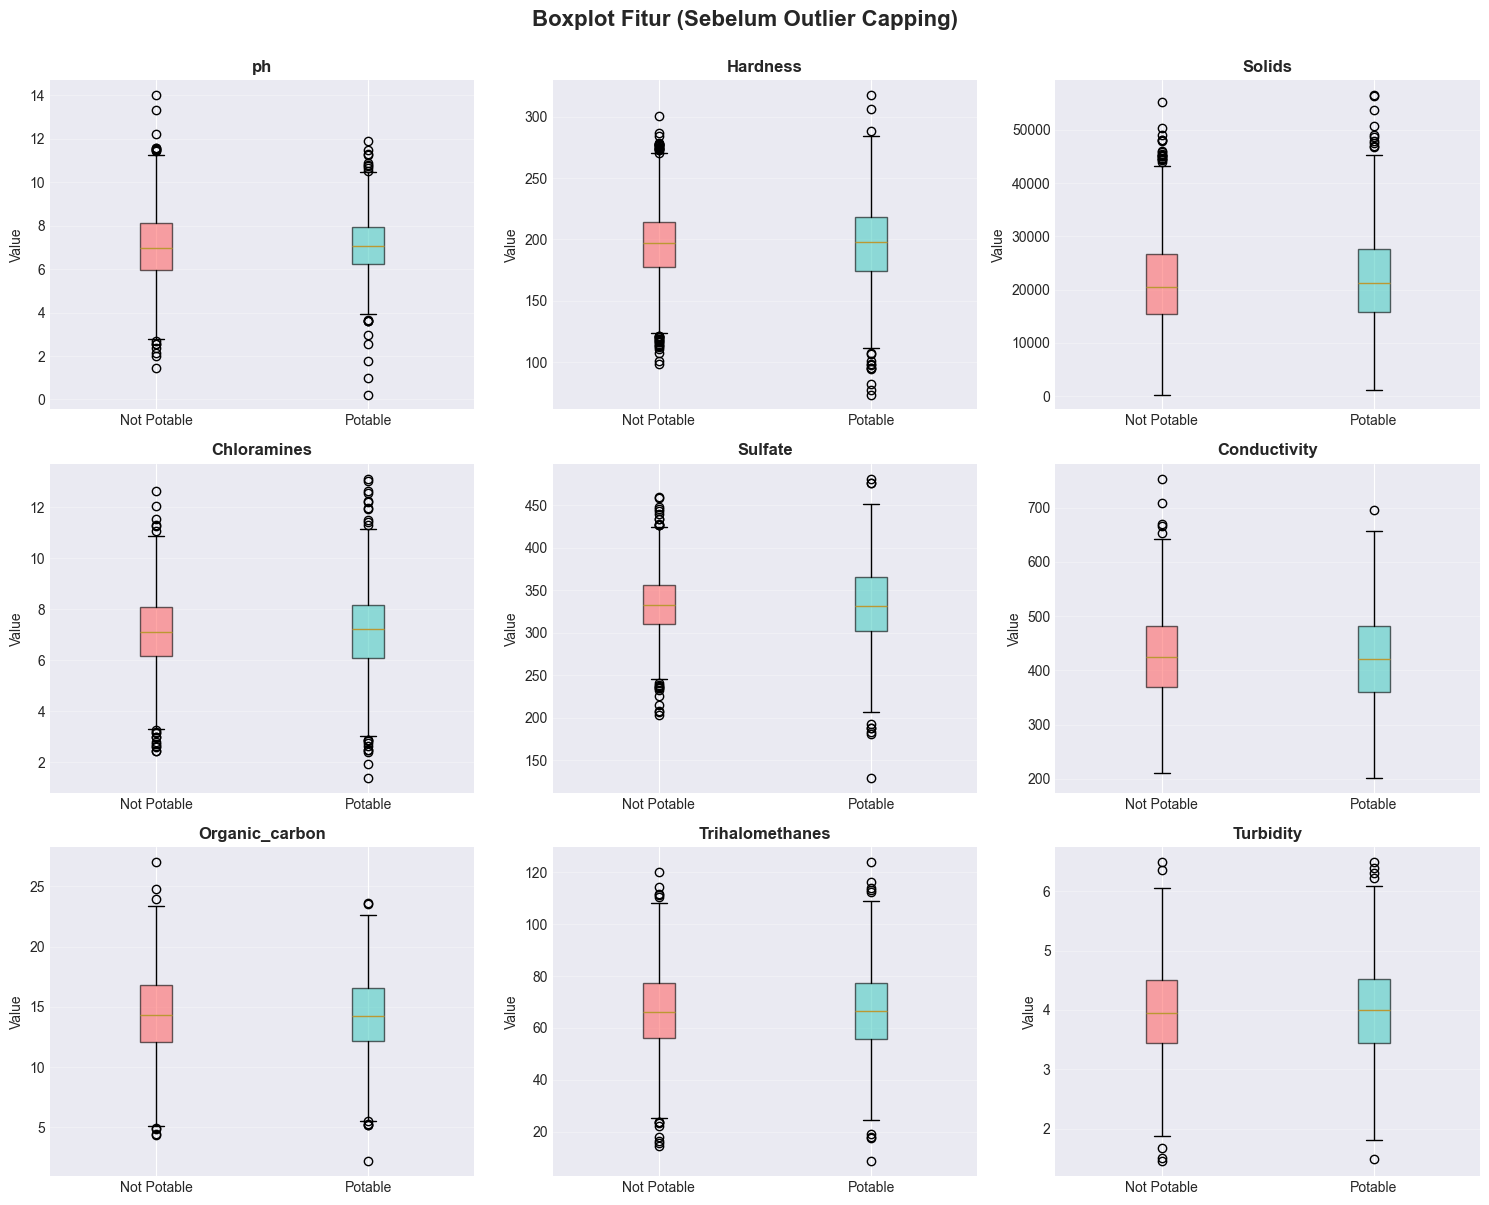

In [ ]:
# Boxplot untuk Outlier Detection (Sebelum Capping)
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.ravel()

for idx, col in enumerate(features):
    bp = axes[idx].boxplot([df[df['Potability']==0][col], df[df['Potability']==1][col]], 
                            tick_labels=['Not Potable', 'Potable'], patch_artist=True)
    for patch, color in zip(bp['boxes'], ['#FF6B6B', '#4ECDC4']):
        patch.set_facecolor(color)
        patch.set_alpha(0.6)
    axes[idx].set_title(col, fontweight='bold')
    axes[idx].set_ylabel('Value')
    axes[idx].grid(alpha=0.3, axis='y')

plt.suptitle('Boxplot Fitur (Sebelum Outlier Capping)', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

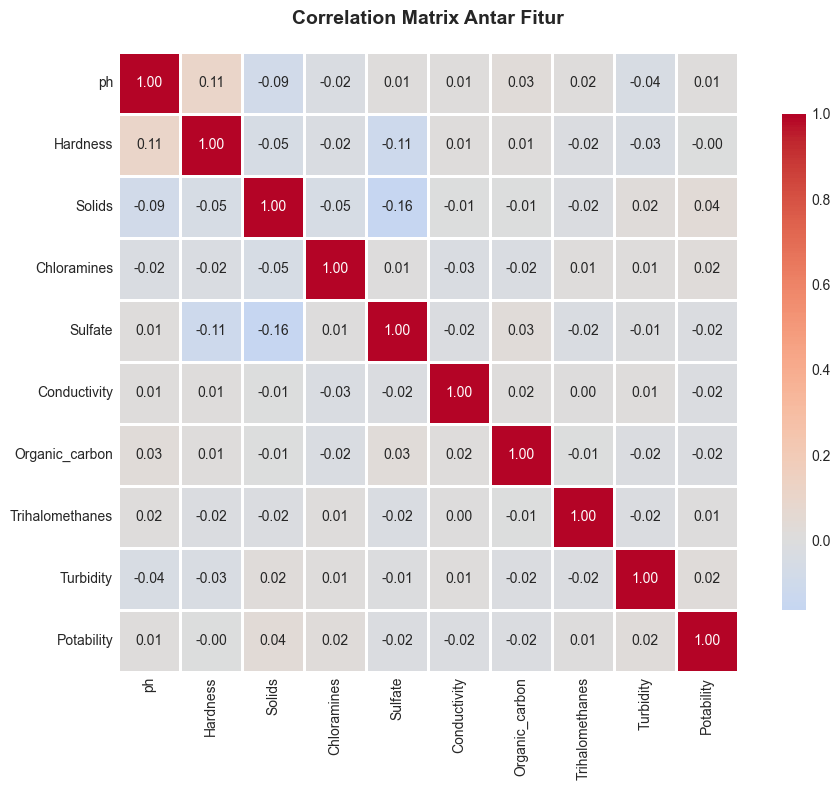


Korelasi Fitur dengan Target (Potability):
Solids             0.040674
Turbidity          0.022682
Chloramines        0.020784
ph                 0.014530
Trihalomethanes    0.009244
Hardness          -0.001505
Sulfate           -0.015303
Conductivity      -0.015496
Organic_carbon    -0.015567
Name: Potability, dtype: float64


In [13]:
# 3. Correlation Heatmap
plt.figure(figsize=(10, 8))
correlation = df.corr()
sns.heatmap(correlation, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix Antar Fitur', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Korelasi dengan target
target_corr = correlation['Potability'].drop('Potability').sort_values(ascending=False)
print("\nKorelasi Fitur dengan Target (Potability):")
print(target_corr)

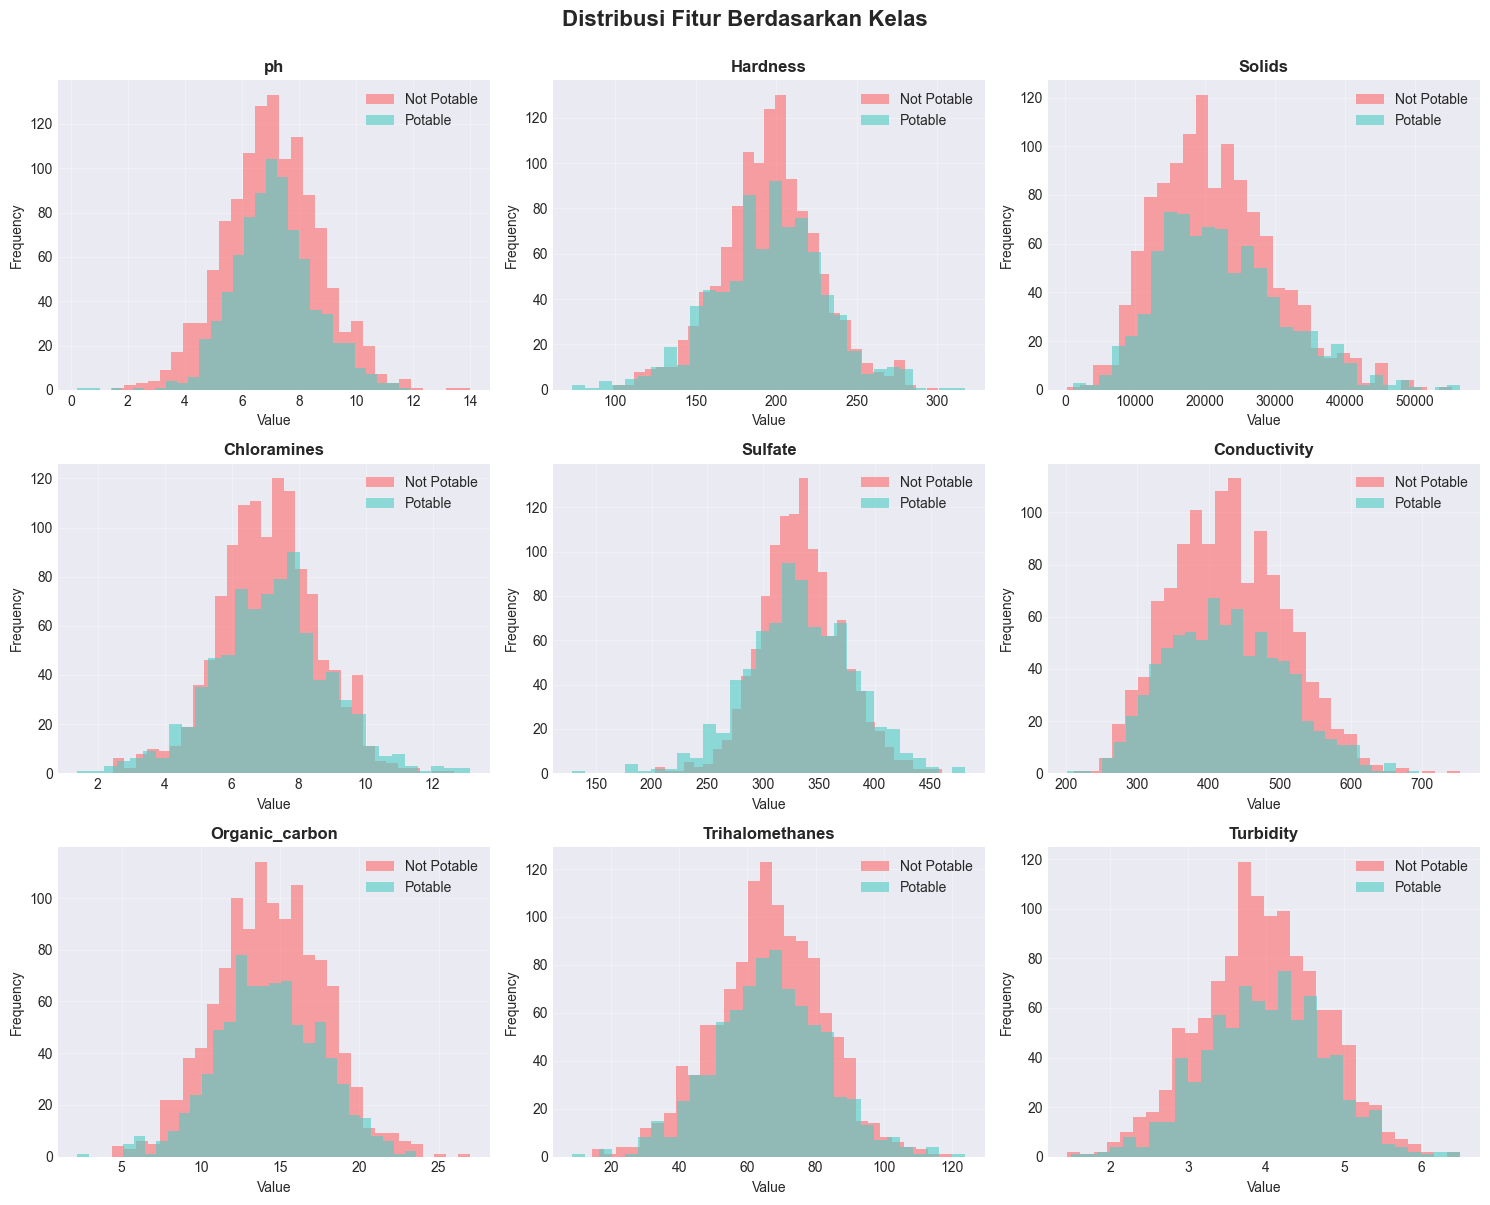

In [14]:
# 2. Distribusi Fitur (Histogram untuk setiap fitur)
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.ravel()

for idx, col in enumerate(features):
    axes[idx].hist(df[df['Potability']==0][col], alpha=0.6, label='Not Potable', bins=30, color='#FF6B6B')
    axes[idx].hist(df[df['Potability']==1][col], alpha=0.6, label='Potable', bins=30, color='#4ECDC4')
    axes[idx].set_title(col, fontweight='bold')
    axes[idx].set_xlabel('Value')
    axes[idx].set_ylabel('Frequency')
    axes[idx].legend()
    axes[idx].grid(alpha=0.3)

plt.suptitle('Distribusi Fitur Berdasarkan Kelas', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

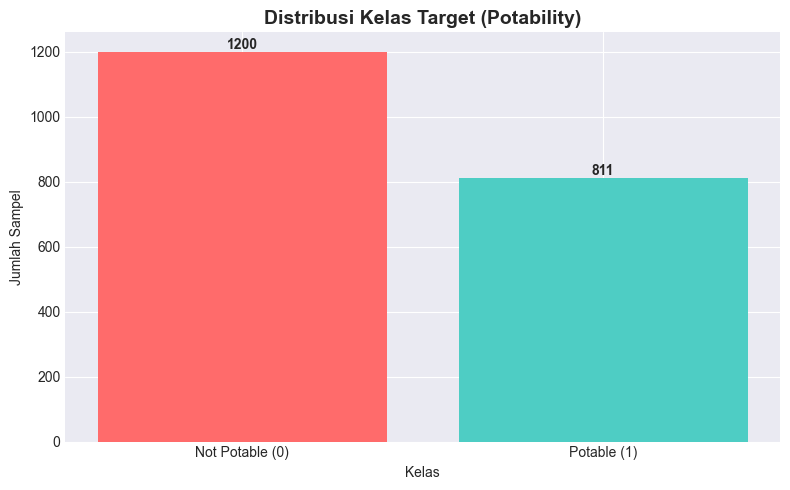

Class 0 (Not Potable): 1200 (59.67%)
Class 1 (Potable): 811 (40.33%)
Balance Ratio: 0.676


In [15]:
# 1. Distribusi Target Variable
plt.figure(figsize=(8, 5))
target_counts = df['Potability'].value_counts()
plt.bar(['Not Potable (0)', 'Potable (1)'], target_counts.values, color=['#FF6B6B', '#4ECDC4'])
plt.title('Distribusi Kelas Target (Potability)', fontsize=14, fontweight='bold')
plt.ylabel('Jumlah Sampel')
plt.xlabel('Kelas')
for i, v in enumerate(target_counts.values):
    plt.text(i, v + 10, str(v), ha='center', fontweight='bold')
plt.tight_layout()
plt.show()

print(f"Class 0 (Not Potable): {target_counts[0]} ({target_counts[0]/len(df)*100:.2f}%)")
print(f"Class 1 (Potable): {target_counts[1]} ({target_counts[1]/len(df)*100:.2f}%)")
print(f"Balance Ratio: {min(target_counts)/max(target_counts):.3f}")

### 2. SPLIT DATA

In [16]:
X = df.drop("Potability", axis=1)
y = df["Potability"]

X_train, X_test, y_train, y_test = train_test_split_stratified(X, y, test_size=0.2, random_state=42)

print(f"Train: {X_train.shape}, Test: {X_test.shape}")

Train: (1609, 9), Test: (402, 9)


### 3. PREPROCESSING

In [17]:
# Outlier capping menggunakan fungsi
X_train_capped, X_test_capped = cap_outliers(X_train, X_test)
# Standardisasi menggunakan data yang sudah di-cap
X_train_prep, X_test_prep = standardize(X_train_capped, X_test_capped)

print("Preprocessing selesai")

Preprocessing selesai


### 3a. VISUALISASI EFEK PREPROCESSING

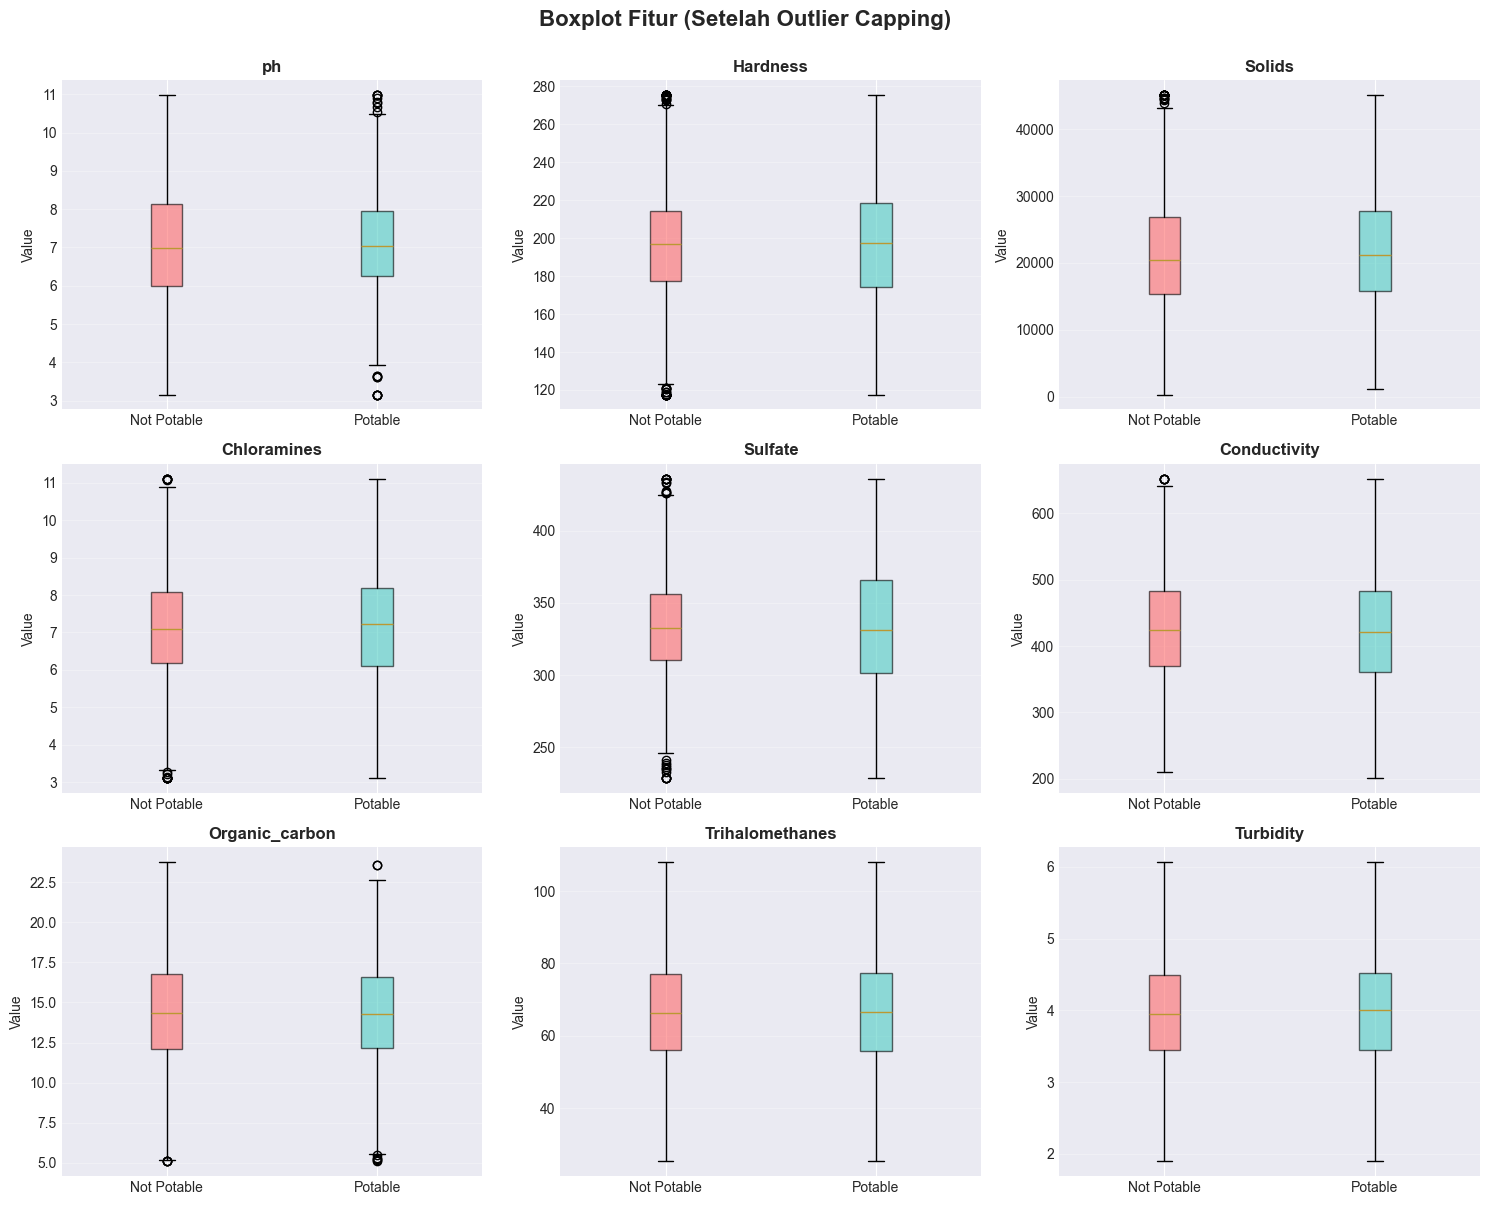

In [18]:
# Boxplot untuk Outlier Detection (Setelah Capping)
# Gabungkan kembali train dan test yang sudah di-cap untuk visualisasi
X_capped_combined = pd.concat([X_train_capped, X_test_capped], ignore_index=True)
y_combined = pd.concat([y_train, y_test], ignore_index=True)

fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.ravel()

for idx, col in enumerate(features):
    bp = axes[idx].boxplot([X_capped_combined[y_combined==0][col], 
                            X_capped_combined[y_combined==1][col]], 
                            tick_labels=['Not Potable', 'Potable'], patch_artist=True)
    for patch, color in zip(bp['boxes'], ['#FF6B6B', '#4ECDC4']):
        patch.set_facecolor(color)
        patch.set_alpha(0.6)
    axes[idx].set_title(col, fontweight='bold')
    axes[idx].set_ylabel('Value')
    axes[idx].grid(alpha=0.3, axis='y')

plt.suptitle('Boxplot Fitur (Setelah Outlier Capping)', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

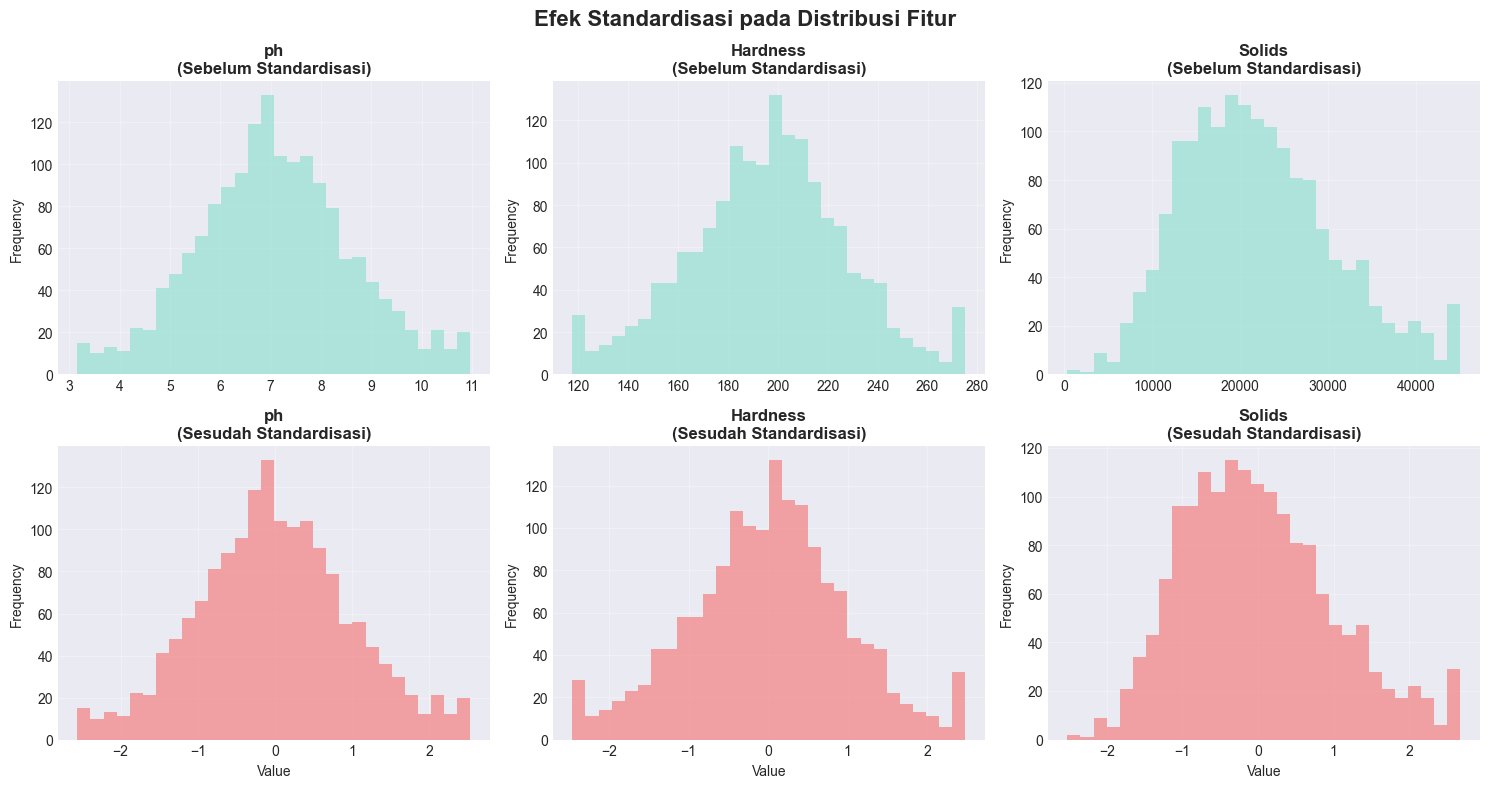

Statistik Sebelum Standardisasi (Train Set - Capped):
            ph    Hardness        Solids
mean  7.084153  196.073899  22029.720593
std   1.532567   31.861678   8609.229061

Statistik Sesudah Standardisasi (Train Set):
                ph      Hardness        Solids
mean -1.357936e-16  4.692055e-16  2.296347e-16
std   1.000000e+00  1.000000e+00  1.000000e+00


In [19]:
# Visualisasi: Sebelum vs Sesudah Standardisasi (sample 3 fitur)
sample_features = features[:3]
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

for idx, col in enumerate(sample_features):
    # Sebelum standardisasi
    axes[0, idx].hist(X_train_capped[col], bins=30, alpha=0.7, color='#95E1D3')
    axes[0, idx].set_title(f'{col}\n(Sebelum Standardisasi)', fontweight='bold')
    axes[0, idx].set_ylabel('Frequency')
    axes[0, idx].grid(alpha=0.3)
    
    # Sesudah standardisasi
    axes[1, idx].hist(X_train_prep[col], bins=30, alpha=0.7, color='#F38181')
    axes[1, idx].set_title(f'{col}\n(Sesudah Standardisasi)', fontweight='bold')
    axes[1, idx].set_xlabel('Value')
    axes[1, idx].set_ylabel('Frequency')
    axes[1, idx].grid(alpha=0.3)

plt.suptitle('Efek Standardisasi pada Distribusi Fitur', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("Statistik Sebelum Standardisasi (Train Set - Capped):")
print(X_train_capped[sample_features].describe().loc[['mean', 'std']])
print("\nStatistik Sesudah Standardisasi (Train Set):")
print(X_train_prep[sample_features].describe().loc[['mean', 'std']])

### 4. GRID SEARCH (OPTIMIZED)

In [20]:
k_values = [5, 7, 9, 11, 15, 19, 25, 31, 41, 51]  # Tambah k besar untuk regularisasi
metrics = ['euclidean', 'manhattan']
weights_options = ['uniform', 'distance']

total_combinations = len(k_values) * len(metrics) * len(weights_options)
print("\n=== Grid Search (Cross-Validation 5-Fold) ===")
print(f"Total kombinasi: {total_combinations}")

best_score = 0
best_params = {}
results = []
current = 0

for k in k_values:
    for metric in metrics:
        for weights in weights_options:
            current += 1
            print(f"[{current}/{total_combinations}] Testing k={k}, metric={metric}, weights={weights}...", end=" ")
            
            mean_score, std_score = cross_validate(X_train, y_train, k, metric, weights, n_folds=5)
            results.append((k, metric, weights, mean_score, std_score))
            
            if mean_score > best_score:
                best_score = mean_score
                best_params = {'k': k, 'metric': metric, 'weights': weights}
            
            print(f"CV Acc: {mean_score:.4f} ± {std_score:.4f}")

print(f"\n>>> BEST: {best_params}")
print(f"    CV Accuracy: {best_score:.4f}")


=== Grid Search (Cross-Validation 5-Fold) ===
Total kombinasi: 40
[1/40] Testing k=5, metric=euclidean, weights=uniform... CV Acc: 0.6215 ± 0.0182
[2/40] Testing k=5, metric=euclidean, weights=distance... CV Acc: 0.6221 ± 0.0184
[3/40] Testing k=5, metric=manhattan, weights=uniform... CV Acc: 0.6221 ± 0.0184
[3/40] Testing k=5, metric=manhattan, weights=uniform... CV Acc: 0.6352 ± 0.0075
[4/40] Testing k=5, metric=manhattan, weights=distance... CV Acc: 0.6346 ± 0.0075
[5/40] Testing k=7, metric=euclidean, weights=uniform... CV Acc: 0.6352 ± 0.0075
[4/40] Testing k=5, metric=manhattan, weights=distance... CV Acc: 0.6346 ± 0.0075
[5/40] Testing k=7, metric=euclidean, weights=uniform... CV Acc: 0.6301 ± 0.0168
[6/40] Testing k=7, metric=euclidean, weights=distance... CV Acc: 0.6301 ± 0.0168
[6/40] Testing k=7, metric=euclidean, weights=distance... CV Acc: 0.6339 ± 0.0169
[7/40] Testing k=7, metric=manhattan, weights=uniform... CV Acc: 0.6370 ± 0.0091
[8/40] Testing k=7, metric=manhattan,

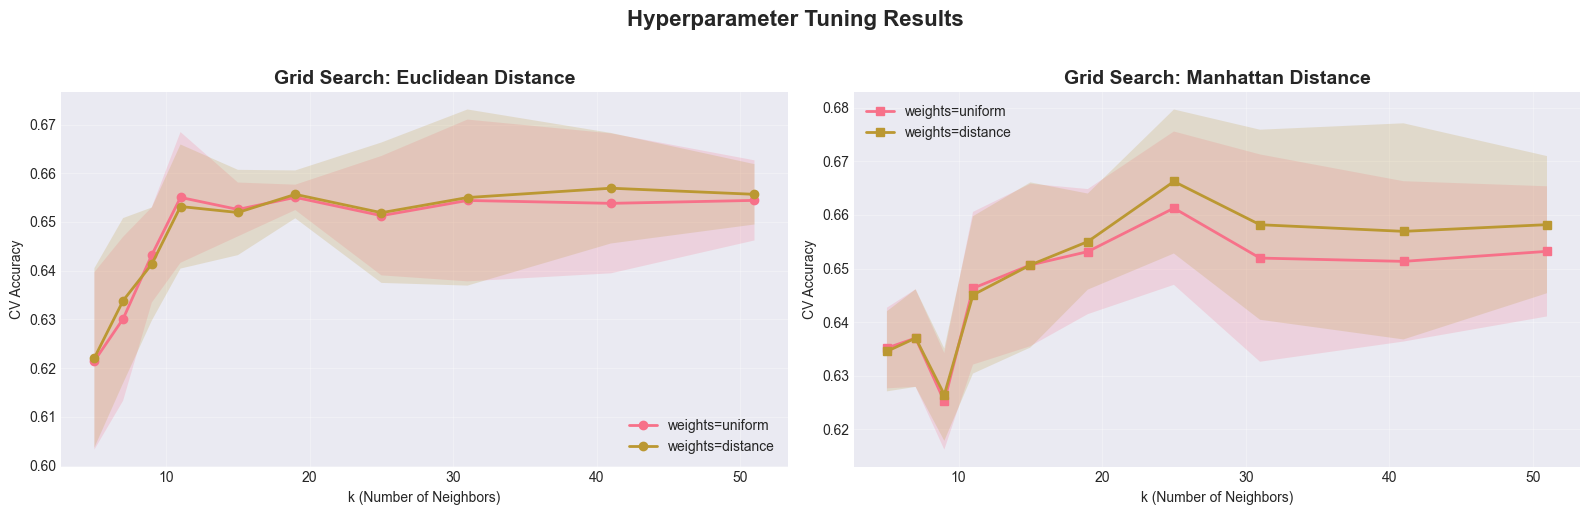


Top 5 Konfigurasi Terbaik:
     k     metric   weights  mean_score  std_score
27  25  manhattan  distance    0.666249   0.013437
26  25  manhattan   uniform    0.661272   0.014306
39  51  manhattan  distance    0.658195   0.012795
31  31  manhattan  distance    0.658180   0.017733
35  41  manhattan  distance    0.656941   0.020166


In [21]:
# Visualisasi Grid Search Results
results_df = pd.DataFrame(results, columns=['k', 'metric', 'weights', 'mean_score', 'std_score'])

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Plot 1: Euclidean
for weights in ['uniform', 'distance']:
    data = results_df[(results_df['metric'] == 'euclidean') & (results_df['weights'] == weights)]
    axes[0].plot(data['k'], data['mean_score'], marker='o', label=f'weights={weights}', linewidth=2)
    axes[0].fill_between(
        data['k'], 
        data['mean_score'] - data['std_score'], 
        data['mean_score'] + data['std_score'], 
        alpha=0.2
    )
axes[0].set_title('Grid Search: Euclidean Distance', fontsize=14, fontweight='bold')
axes[0].set_xlabel('k (Number of Neighbors)')
axes[0].set_ylabel('CV Accuracy')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Plot 2: Manhattan
for weights in ['uniform', 'distance']:
    data = results_df[(results_df['metric'] == 'manhattan') & (results_df['weights'] == weights)]
    axes[1].plot(data['k'], data['mean_score'], marker='s', label=f'weights={weights}', linewidth=2)
    axes[1].fill_between(
        data['k'], 
        data['mean_score'] - data['std_score'], 
        data['mean_score'] + data['std_score'], 
        alpha=0.2
    )
axes[1].set_title('Grid Search: Manhattan Distance', fontsize=14, fontweight='bold')
axes[1].set_xlabel('k (Number of Neighbors)')
axes[1].set_ylabel('CV Accuracy')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.suptitle('Hyperparameter Tuning Results', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Tabel Top 5 Configurations
print("\nTop 5 Konfigurasi Terbaik:")
print(results_df.sort_values('mean_score', ascending=False).head())

### 5. EVALUASI LENGKAP: TRAIN, TEST, DAN FULL DATASET

In [22]:
def print_evaluation(y_true, y_pred, dataset_name):
    """
    Print metrik evaluasi.
    I.S. y_true: label asli, y_pred: label prediksi, dataset_name: nama dataset
    F.S : print metrik evaluasi
    """
    acc = accuracy(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    
    print(f"\n=== {dataset_name} ===")
    print(f"Akurasi: {acc:.4f}")
    print(f"Confusion Matrix:")
    print(cm)
    
    tn, fp, fn, tp = cm[0,0], cm[0,1], cm[1,0], cm[1,1]
    precision_0 = tn / (tn + fn) if (tn + fn) > 0 else 0
    recall_0 = tn / (tn + fp) if (tn + fp) > 0 else 0
    f1_0 = 2 * precision_0 * recall_0 / (precision_0 + recall_0) if (precision_0 + recall_0) > 0 else 0
    
    precision_1 = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall_1 = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_1 = 2 * precision_1 * recall_1 / (precision_1 + recall_1) if (precision_1 + recall_1) > 0 else 0
    
    print(f"\nClassification Report:")
    print(f"              precision    recall  f1-score   support")
    print(f"           0     {precision_0:.4f}    {recall_0:.4f}    {f1_0:.4f}       {tn+fp}")
    print(f"           1     {precision_1:.4f}    {recall_1:.4f}    {f1_1:.4f}       {fn+tp}")
    print(f"    accuracy                         {acc:.4f}       {len(y_true)}")
    print(f"   macro avg     {(precision_0+precision_1)/2:.4f}    {(recall_0+recall_1)/2:.4f}    {(f1_0+f1_1)/2:.4f}       {len(y_true)}")

### 5a. Evaluasi di TRAINING SET (untuk cek overfitting)

In [23]:
print("\n" + "="*70)
print("EVALUASI MODEL DENGAN HYPERPARAMETER TERBAIK")
print("="*70)

print("Menghitung prediksi training set dengan Leave-One-Out (lambat)...")
y_pred_train = knn_predict(
    X_train_prep, y_train, X_train_prep, 
    k=best_params['k'], 
    metric=best_params['metric'], 
    weights=best_params['weights']
)
print_evaluation(y_train.values, y_pred_train, "TRAINING SET (Leave-One-Out)")


EVALUASI MODEL DENGAN HYPERPARAMETER TERBAIK
Menghitung prediksi training set dengan Leave-One-Out (lambat)...

=== TRAINING SET (Leave-One-Out) ===
Akurasi: 1.0000
Confusion Matrix:
[[960   0]
 [  0 649]]

Classification Report:
              precision    recall  f1-score   support
           0     1.0000    1.0000    1.0000       960
           1     1.0000    1.0000    1.0000       649
    accuracy                         1.0000       1609
   macro avg     1.0000    1.0000    1.0000       1609


### 5b. Evaluasi di TEST SET (held-out data)

In [24]:
y_pred_test = knn_predict(
    X_train_prep, y_train, X_test_prep, 
    k=best_params['k'], 
    metric=best_params['metric'], 
    weights=best_params['weights']
)
print_evaluation(y_test.values, y_pred_test, "TEST SET")


=== TEST SET ===
Akurasi: 0.6493
Confusion Matrix:
[[222  18]
 [123  39]]

Classification Report:
              precision    recall  f1-score   support
           0     0.6435    0.9250    0.7590       240
           1     0.6842    0.2407    0.3562       162
    accuracy                         0.6493       402
   macro avg     0.6638    0.5829    0.5576       402


### 5c. Evaluasi di FULL DATASET (keseluruhan data awal)

In [25]:
# Preprocess full dataset
X_full = df.drop("Potability", axis=1)
y_full = df["Potability"]

X_full_scaled = (X_full - X_train.mean()) / X_train.std()  # Gunakan mean/std dari train

y_pred_full = knn_predict(
    X_train_prep, y_train, X_full_scaled,
    k=best_params['k'], 
    metric=best_params['metric'], 
    weights=best_params['weights']
)
print_evaluation(y_full.values, y_pred_full, "FULL DATASET (SEMUA DATA AWAL)")


=== FULL DATASET (SEMUA DATA AWAL) ===
Akurasi: 0.9284
Confusion Matrix:
[[1181   19]
 [ 125  686]]

Classification Report:
              precision    recall  f1-score   support
           0     0.9043    0.9842    0.9425       1200
           1     0.9730    0.8459    0.9050       811
    accuracy                         0.9284       2011
   macro avg     0.9387    0.9150    0.9238       2011


### 5d. Evaluasi di CV (Cross-Validation Predictions)

In [26]:
# Dapatkan prediksi CV dengan menjalankan cross-validation lengkap
print("Menghitung prediksi CV (5-Fold)...")

# Setup untuk menyimpan prediksi CV
np.random.seed(42)
indices = np.arange(len(X_train))
np.random.shuffle(indices)

fold_size = len(X_train) // 5
y_pred_cv_all = np.zeros(len(X_train))

for fold in range(5):
    print(f"Processing fold {fold+1}/5...")
    # Split indices
    test_start = fold * fold_size
    test_end = test_start + fold_size if fold < 4 else len(X_train)
    
    test_indices = indices[test_start:test_end]
    train_indices = np.concatenate([indices[:test_start], indices[test_end:]])
    
    # Split data
    X_fold_train = X_train.iloc[train_indices].reset_index(drop=True)
    y_fold_train = y_train.iloc[train_indices].reset_index(drop=True)
    X_fold_test = X_train.iloc[test_indices].reset_index(drop=True)
    y_fold_test = y_train.iloc[test_indices].reset_index(drop=True)
    
    # Preprocess
    X_fold_train_scaled, X_fold_test_scaled = standardize(X_fold_train, X_fold_test)
    
    # Predict
    y_pred_fold = knn_predict(
        X_fold_train_scaled, y_fold_train, X_fold_test_scaled,
        k=best_params['k'], 
        metric=best_params['metric'], 
        weights=best_params['weights']
    )
    
    # Simpan prediksi ke posisi aslinya
    y_pred_cv_all[test_indices] = y_pred_fold

# Evaluasi CV
print_evaluation(y_train.values, y_pred_cv_all, "CROSS-VALIDATION (5-Fold)")

Menghitung prediksi CV (5-Fold)...
Processing fold 1/5...
Processing fold 2/5...
Processing fold 3/5...
Processing fold 4/5...
Processing fold 5/5...

=== CROSS-VALIDATION (5-Fold) ===
Akurasi: 0.6663
Confusion Matrix:
[[882  78]
 [459 190]]

Classification Report:
              precision    recall  f1-score   support
           0     0.6577    0.9187    0.7666       960
           1     0.7090    0.2928    0.4144       649
    accuracy                         0.6663       1609
   macro avg     0.6833    0.6058    0.5905       1609


In [27]:
print("\n" + "="*70)
print("ANALISIS KINERJA (CV Score vs Test Score)")
print("="*70)

# Ambil score dari berbagai evaluasi
train_acc = accuracy(y_train.values, y_pred_train)
cv_acc_actual = accuracy(y_train.values, y_pred_cv_all)  # Dari prediksi CV yang baru dihitung
cv_acc_mean = best_score  # Mean dari grid search
test_acc = accuracy(y_test.values, y_pred_test)
full_acc = accuracy(y_full.values, y_pred_full)

print(f"Akurasi Training:        {train_acc:.4f}")
print(f"Akurasi CV (Actual):     {cv_acc_actual:.4f}")
print(f"Akurasi CV (Mean):       {cv_acc_mean:.4f}")
print(f"Akurasi Test:            {test_acc:.4f}")
print(f"Akurasi Full:            {full_acc:.4f}")

print("\nKESIMPULAN:")
if best_params['weights'] == 'distance':
    print("Catatan: Training Accuracy sangat tinggi untuk weights='distance' (ekspektasi ~95-100%).")
    print("         karena setiap titik adalah tetangga terdekat dari dirinya sendiri.")
    print(f"\nGap (CV - Test):   {cv_acc_actual - test_acc:.4f}")
    print(f"Gap (Train - Test): {train_acc - test_acc:.4f}")
    
    # Untuk weights='distance', fokus pada CV vs Test (lebih reliable)
    if cv_acc_actual - test_acc > 0.08:  # Threshold lebih ketat untuk CV
        print("\n! WASPADA: Terindikasi OVERFITTING.")
        print("  Skor cross-validation lebih tinggi dari test set.")
        print("  Model terlalu menyesuaikan dengan training data.")
        print("  Solusi: Tingkatkan k (lebih banyak tetangga = lebih smooth)")
    elif test_acc < 0.60:  # Threshold bisa disesuaikan domain
        print("\n! UNDERFITTING.")
        print("  Akurasi test set terlalu rendah.")
        print("  Solusi: Kurangi k atau tambah fitur yang lebih informatif")
    else:
        print("\n✓ MODEL STABIL (Good Fit).")
        print("  Performa CV dan Test konsisten, generalisasi baik.")
        
elif best_params['weights'] == 'uniform':
    # Untuk uniform, train vs test lebih informatif
    print(f"Gap (CV - Test):    {cv_acc_actual - test_acc:.4f}")
    print(f"Gap (Train - Test): {train_acc - test_acc:.4f}")
    
    if train_acc - test_acc > 0.10:  # Threshold untuk uniform
        print("\n! Indikasi OVERFITTING (Gap Train-Test besar).")
        print("  Model terlalu 'hafal' training data.")
        print("  Solusi: Tingkatkan k atau regularisasi lainnya")
    elif cv_acc_actual - test_acc > 0.08:
        print("\n! Indikasi OVERFITTING ringan (berdasarkan CV vs Test).")
    elif test_acc < 0.60:
        print("\n! UNDERFITTING.")
        print("  Performa keseluruhan rendah.")
    else:
        print("\n✓ MODEL KONSISTEN (Good Fit).")
        print("  Gap train-test dalam batas wajar.")


ANALISIS KINERJA (CV Score vs Test Score)
Akurasi Training:        1.0000
Akurasi CV (Actual):     0.6663
Akurasi CV (Mean):       0.6662
Akurasi Test:            0.6493
Akurasi Full:            0.9284

KESIMPULAN:
Catatan: Training Accuracy sangat tinggi untuk weights='distance' (ekspektasi ~95-100%).
         karena setiap titik adalah tetangga terdekat dari dirinya sendiri.

Gap (CV - Test):   0.0170
Gap (Train - Test): 0.3507

✓ MODEL STABIL (Good Fit).
  Performa CV dan Test konsisten, generalisasi baik.


### 5e. VISUALISASI CONFUSION MATRIX & METRICS

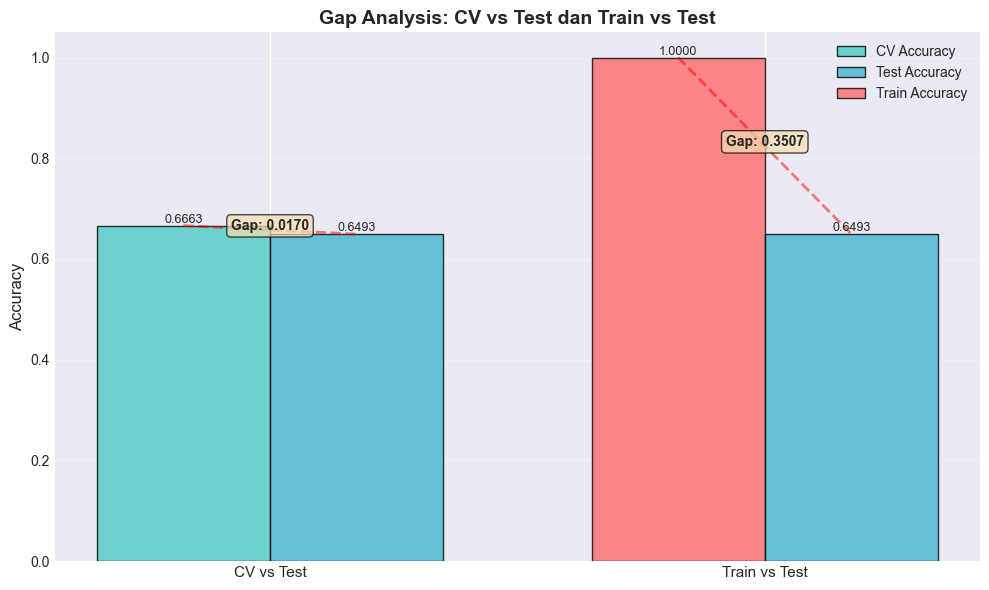

In [28]:
# Learning Curve Visualization (Gap Analysis)
plt.figure(figsize=(10, 6))

# Data untuk visualisasi gap - hanya CV vs Test dan Train vs Test
x_pos = np.arange(2)
labels = ['CV vs Test', 'Train vs Test']

# Persiapkan data
cv_test_pair = [cv_acc_actual, test_acc]
train_test_pair = [train_acc, test_acc]

width = 0.35

# Plot CV vs Test
bars1 = plt.bar(0 - width/2, cv_acc_actual, width, label='CV Accuracy', 
                color='#4ECDC4', alpha=0.8, edgecolor='black')
bars2 = plt.bar(0 + width/2, test_acc, width, label='Test Accuracy', 
                color='#45B7D1', alpha=0.8, edgecolor='black')

# Plot Train vs Test
bars3 = plt.bar(1 - width/2, train_acc, width, label='Train Accuracy', 
                color='#FF6B6B', alpha=0.8, edgecolor='black')
bars4 = plt.bar(1 + width/2, test_acc, width, 
                color='#45B7D1', alpha=0.8, edgecolor='black')

# Highlight gaps dengan garis dan label
gap_cv_test = cv_acc_actual - test_acc
gap_train_test = train_acc - test_acc

# Gap untuk CV vs Test
plt.plot([0-width/2, 0+width/2], [cv_acc_actual, test_acc], 'r--', alpha=0.5, linewidth=2)
mid_point_cv = (cv_acc_actual + test_acc) / 2
plt.text(0, mid_point_cv, f'Gap: {gap_cv_test:.4f}', ha='center', 
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7), fontsize=10, fontweight='bold')

# Gap untuk Train vs Test
plt.plot([1-width/2, 1+width/2], [train_acc, test_acc], 'r--', alpha=0.5, linewidth=2)
mid_point_train = (train_acc + test_acc) / 2
plt.text(1, mid_point_train, f'Gap: {gap_train_test:.4f}', ha='center', 
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7), fontsize=10, fontweight='bold')

plt.ylabel('Accuracy', fontsize=12)
plt.title('Gap Analysis: CV vs Test dan Train vs Test', fontsize=14, fontweight='bold')
plt.xticks(x_pos, labels, fontsize=11)
plt.ylim([0, 1.05])
plt.legend(loc='upper right')
plt.grid(alpha=0.3, axis='y')

# Add value labels
for bar in [bars1, bars2, bars3, bars4]:
    for b in bar:
        height = b.get_height()
        plt.text(b.get_x() + b.get_width()/2., height,
                 f'{height:.4f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

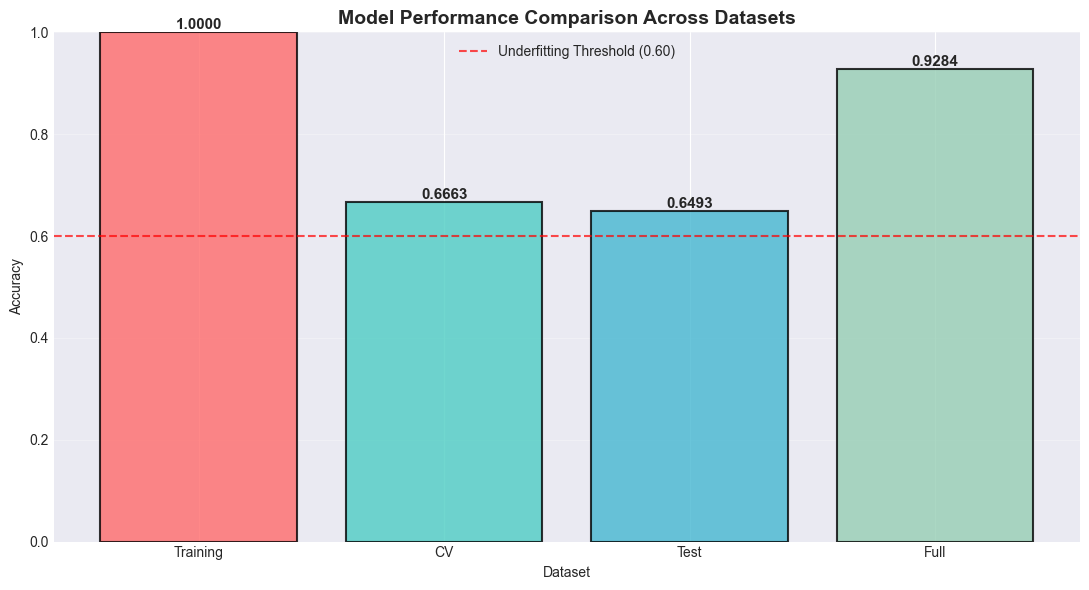

In [29]:
# Bar Chart: Accuracy Comparison (dengan CV Actual)
datasets = ['Training', 'CV', 'Test', 'Full']
accuracies = [train_acc, cv_acc_actual, test_acc, full_acc]
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']

plt.figure(figsize=(11, 6))
bars = plt.bar(datasets, accuracies, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)

# Add value labels on bars
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2., height,
        f'{acc:.4f}',
        ha='center', va='bottom', fontweight='bold', fontsize=11
    )

plt.title('Model Performance Comparison Across Datasets', fontsize=14, fontweight='bold')
plt.ylabel('Accuracy')
plt.xlabel('Dataset')
plt.ylim([0, 1.0])
plt.axhline(y=0.6, color='red', linestyle='--', label='Underfitting Threshold (0.60)', alpha=0.7)
plt.grid(alpha=0.3, axis='y')
plt.legend()
plt.tight_layout()
plt.show()

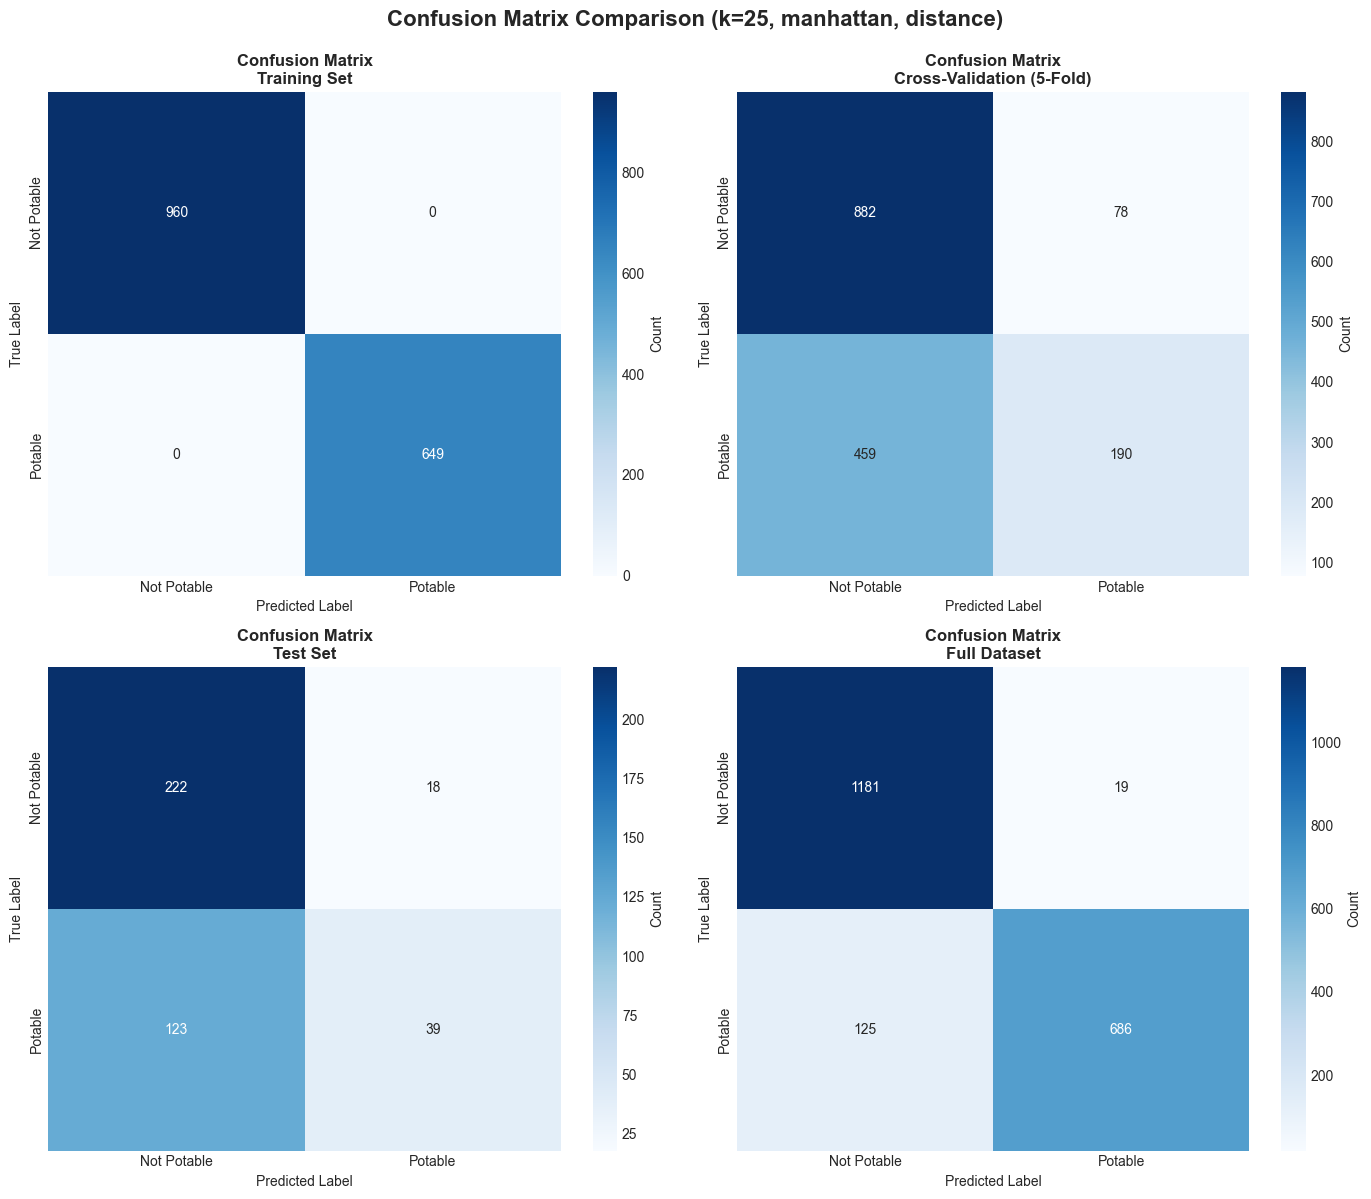

In [30]:
# Visualisasi Confusion Matrix untuk Train, CV, Test, dan Full
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.ravel()

cm_train = confusion_matrix(y_train.values, y_pred_train)
cm_cv = confusion_matrix(y_train.values, y_pred_cv_all)
cm_test = confusion_matrix(y_test.values, y_pred_test)
cm_full = confusion_matrix(y_full.values, y_pred_full)

for idx, (cm, title) in enumerate(
    [(cm_train, 'Training Set'), 
    (cm_cv, 'Cross-Validation (5-Fold)'),
    (cm_test, 'Test Set'), 
    (cm_full, 'Full Dataset')]
):
    sns.heatmap(
        cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx], 
        xticklabels=['Not Potable', 'Potable'],
        yticklabels=['Not Potable', 'Potable'],
        cbar_kws={'label': 'Count'}
    )
    axes[idx].set_title(f'Confusion Matrix\n{title}', fontweight='bold', fontsize=12)
    axes[idx].set_ylabel('True Label')
    axes[idx].set_xlabel('Predicted Label')

plt.suptitle(
    f'Confusion Matrix Comparison (k={best_params["k"]}, {best_params["metric"]}, {best_params["weights"]})', 
    fontsize=16, fontweight='bold', y=0.995
)
plt.tight_layout()
plt.show()